<a href="https://colab.research.google.com/github/GahSales/image_processing/blob/main/fastai_image_classificator_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Imports necessários**

In [ ]:
import fastai
import pandas as pd
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.data.all import *

**Lendo metadata**

In [ ]:
csv_path = "gdrive/MyDrive/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
skin_df = pd.read_csv(csv_path)
skin_df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [ ]:
path = Path('gdrive/MyDrive/kaggle/input/skin-cancer-mnist-ham10000/')
Path.BASE_PATH = path
path.ls()

(#7) [Path('HAM10000_metadata.csv'),Path('hmnist_28_28_L.csv'),Path('hmnist_28_28_RGB.csv'),Path('hmnist_8_8_RGB.csv'),Path('hmnist_8_8_L.csv'),Path('HAM10000_images_part_1'),Path('HAM10000_images_part_2')]

**Traduzindo os codigos dos arquivos para os nomes das doenças**

In [ ]:
short_to_full_name_dict = {
    "akiec" : "Doença de Bowen", # lesoes pre-cancerigenas 
    "bcc" : "Carcinoma basocelular" , # tipo de cancer de pele mais comum, mas o menos agressivo
    "bkl" : "Queratose actinica benigna", # lesoes pre-malignas
    "df" : "dermatofibroma", # lesao benigna de coloracao acastanhada
    "mel" : "melanoma", # cancer de pele com manchas escuras
    "nv" : "nevo melanocitico", # conhecidos popularmente como sinais, pintas ou verrugas
    "vasc" : "Lesoes vasculares", # manchas 
}

**Pegando as imagens dos arquivos**

In [ ]:
img_to_class_dict = skin_df.loc[:, ["image_id", "dx"]] 
img_to_class_dict = img_to_class_dict.to_dict('list')  
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) } 
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'Queratose actinica benigna'),
 ('ISIC_0025030', 'Queratose actinica benigna'),
 ('ISIC_0026769', 'Queratose actinica benigna'),
 ('ISIC_0025661', 'Queratose actinica benigna'),
 ('ISIC_0031633', 'Queratose actinica benigna')]

In [ ]:
# path.stem returns the filename without suffix
def get_label_from_dict(path):
    return img_to_class_dict[path.stem] 

**Designando cada ID da imagem para uma doença específica**

In [ ]:
dblock = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = get_label_from_dict,
    item_tfms=[Resize(448), DihedralItem()],
    batch_tfms=RandomResizedCrop(size=224, min_scale=0.75, max_scale=1.0))

img_path = "gdrive/MyDrive/kaggle/input/skin-cancer-mnist-ham10000/"  
dls = dblock.dataloaders(img_path, bs=64) 

**Output de exemplo de imagens com suas respectivas designações**

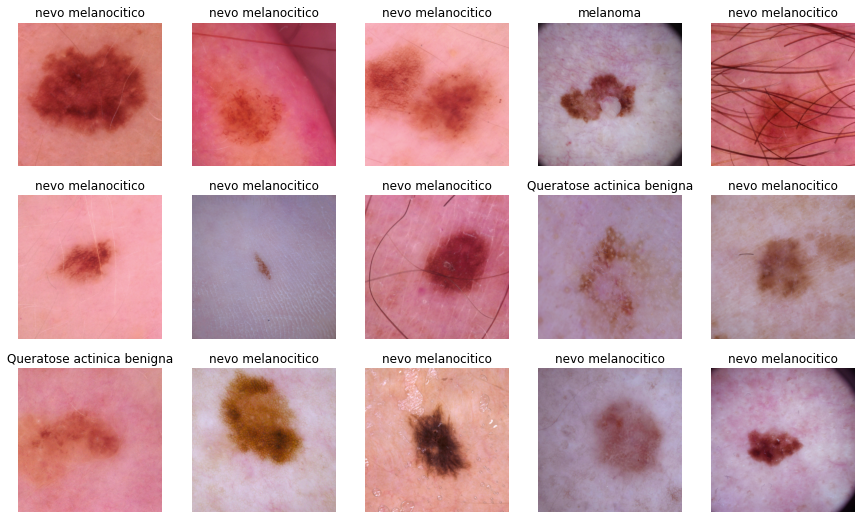

In [ ]:
dls.show_batch(max_n=15)

In [ ]:
print(dls.vocab)
len(dls.train_ds), len(dls.valid_ds)

['Carcinoma basocelular', 'Doença de Bowen', 'Lesoes vasculares', 'Queratose actinica benigna', 'dermatofibroma', 'melanoma', 'nevo melanocitico']


(8012, 2003)

**Treinamento da IA para a detecção dos diferentes tipos de lesões de pele**

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy, opt_func=ranger)
learn.fine_tune(epochs=5, freeze_epochs=3, base_lr=0.005, cbs=MixUp(0.5))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.562013,1.518351,0.558163,34:04
1,1.544638,0.751694,0.752371,02:47
2,1.067998,0.648603,0.768348,02:42


epoch,train_loss,valid_loss,accuracy,time
0,0.873219,0.564855,0.801797,02:46
1,0.803518,0.563673,0.800300,02:47
2,0.746571,0.433260,0.854718,02:47
3,0.673749,0.399148,0.865202,02:48
4,0.631585,0.387487,0.868697,02:46


**Gráfico mostrando a classificação final da IA versus a correta classificação desejada**

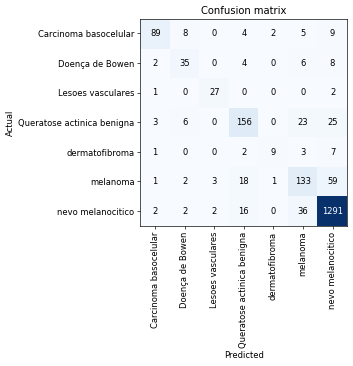

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)